In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import os

In [1]:
def preprocess_image(img):
    resized = cv2.resize(img, (400, 300))
    filtered = cv2.medianBlur(resized, 5)
    return resized, filtered

In [3]:
def segment_colors(img, k=3):
    img_reshaped = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(img_reshaped)
    segmented_img = kmeans.cluster_centers_[labels].reshape(img.shape)
    return segmented_img.astype('uint8')

In [4]:
def extract_features(img):
    # Handle both grayscale and BGR input
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    harris = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    harris = cv2.dilate(harris, None)
    keypoints = np.argwhere(harris > 0.01 * harris.max())
    keypoints_cv = [cv2.KeyPoint(float(p[1]), float(p[0]), 1) for p in keypoints]

    try:
        freak = cv2.xfeatures2d.FREAK_create()
    except:
        print("FREAK not available. Install opencv-contrib-python.")
        return None

    keypoints_cv, descriptors = freak.compute(gray, keypoints_cv)
    return descriptors

In [5]:
def load_reference_descriptors(path):
    if os.path.exists(path):
        return np.load(path)
    else:
        print("Reference descriptors not found. Run descriptor extraction first.")
        return None

In [6]:
def match_features(desc1, desc2, threshold=0.2):
    if desc1 is None or desc2 is None:
        return 0.0
    matches = 0
    for d1 in desc1:
        dists = np.sum((desc2 - d1) ** 2, axis=1)
        if np.min(dists) < threshold:
            matches += 1
    return matches / len(desc1) if len(desc1) > 0 else 0.0


In [57]:
data_root = "Data"
categories = ["guns"]
output_dir = "features"
os.makedirs(output_dir, exist_ok=True)

for category in categories:
    category_path = os.path.join(data_root, category)
    all_descriptors = []

    for filename in os.listdir(category_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue

            resized, filtered = preprocess_image(img)
            segmented = segment_colors(filtered, k=3)
            gray = cv2.cvtColor(segmented.astype('uint8'), cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

            descriptors = extract_features(closed)
            if descriptors is not None:
                all_descriptors.append(descriptors)

    if all_descriptors:
        combined_descriptors = np.vstack(all_descriptors)
        np.save(os.path.join(output_dir, f"{category}_descriptors.npy"), combined_descriptors)
        print(f"[{category}] Saved {combined_descriptors.shape[0]} descriptors.")
    else:
        print(f"[{category}] No descriptors were extracted.")

[guns] Saved 245320 descriptors.


In [7]:
reference_descriptors = load_reference_descriptors(r"G:\Work\visual recognition\project\features\guns_descriptors.npy")

In [59]:
# Load and process image
img_path = r"G:\Work\visual recognition\project\Data\test\gun\gun1.jpeg"
img = cv2.imread(img_path)
resized, filtered = preprocess_image(img)

# Segment image using K-means
segmented = segment_colors(filtered, k=3)

# Convert to grayscale and apply threshold for morphology
gray = cv2.cvtColor(segmented.astype('uint8'), cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

# Morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Extract features using Harris and FREAK
descriptors = extract_features(closed)

# Match against reference and classify
if descriptors is not None:
    matched_ratio = match_features(descriptors, reference_descriptors)
    if matched_ratio >= 0.5:
        print("Gun detected in image.")
    else:
        print("No gun detected.")
else:
    print("No descriptors extracted.")

Gun detected in image.


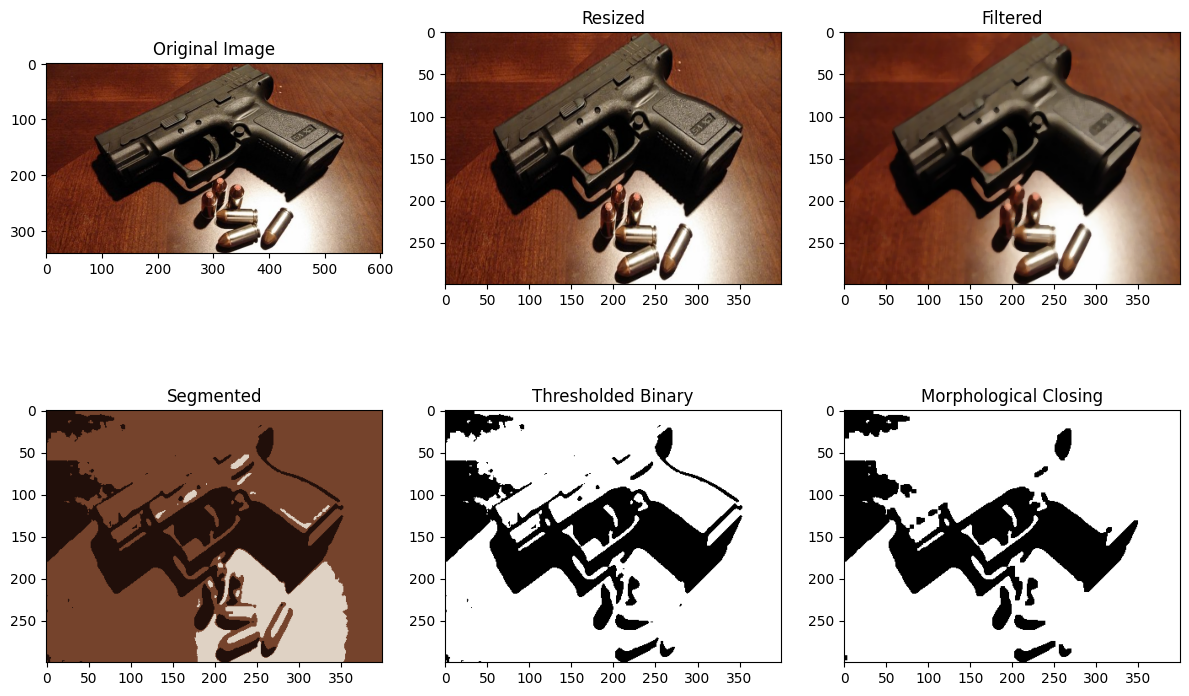

In [60]:
import matplotlib.pyplot as plt

# Show original, resized/filtered, and segmented
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Resized")

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
plt.title("Filtered")

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title("Segmented")

plt.subplot(2, 3, 5)
plt.imshow(binary, cmap='gray')
plt.title("Thresholded Binary")

plt.subplot(2, 3, 6)
plt.imshow(closed, cmap='gray')
plt.title("Morphological Closing")

plt.tight_layout()
plt.show()


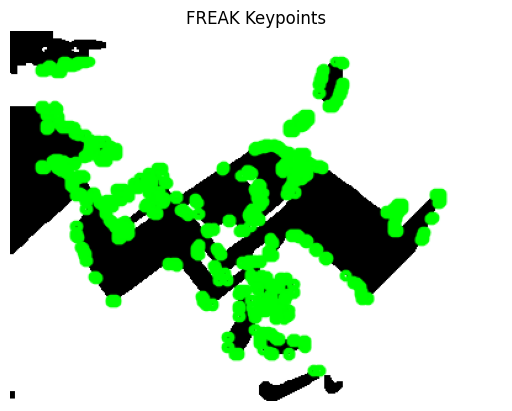

In [61]:
if descriptors is not None:
    gray = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
    harris = cv2.cornerHarris(np.float32(cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)), 2, 3, 0.04)
    harris = cv2.dilate(harris, None)
    keypoints = np.argwhere(harris > 0.01 * harris.max())
    keypoints_cv = [cv2.KeyPoint(float(p[1]), float(p[0]), 1) for p in keypoints]

    try:
        freak = cv2.xfeatures2d.FREAK_create()
        keypoints_cv, _ = freak.compute(cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY), keypoints_cv)
        img_keypoints = cv2.drawKeypoints(gray, keypoints_cv, None, color=(0, 255, 0))
        plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
        plt.title("FREAK Keypoints")
        plt.axis('off')
        plt.show()
    except:
        print("FREAK not available.")


In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [63]:
def compare_feature_extractors(img_gray):
    results = {}

    # Harris + FREAK
    harris = cv2.cornerHarris(np.float32(img_gray), 2, 3, 0.04)
    harris = cv2.dilate(harris, None)
    keypoints = np.argwhere(harris > 0.01 * harris.max())
    keypoints_cv = [cv2.KeyPoint(float(p[1]), float(p[0]), 1) for p in keypoints]

    try:
        freak = cv2.xfeatures2d.FREAK_create()
        kp_freak, desc_freak = freak.compute(img_gray, keypoints_cv)
        results['FREAK'] = (kp_freak, desc_freak)
    except:
        print("FREAK not available.")

    # SIFT
    try:
        sift = cv2.SIFT_create()
        kp_sift, desc_sift = sift.detectAndCompute(img_gray, None)
        results['SIFT'] = (kp_sift, desc_sift)
    except:
        print("SIFT not available.")

    # ORB
    orb = cv2.ORB_create()
    kp_orb, desc_orb = orb.detectAndCompute(img_gray, None)
    results['ORB'] = (kp_orb, desc_orb)

    return results


def visualize_keypoints(img, keypoints_dict):
    for name, (kp, _) in keypoints_dict.items():
        img_kp = cv2.drawKeypoints(img.copy(), kp, None, color=(0, 255, 0))
        plt.figure(figsize=(6, 4))
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.title(f"{name} Keypoints: {len(kp)} detected")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


Feature extraction time: 0.06 seconds


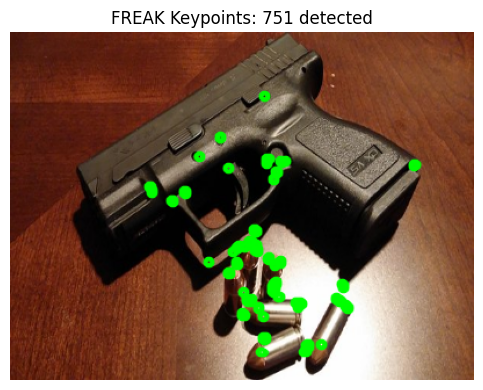

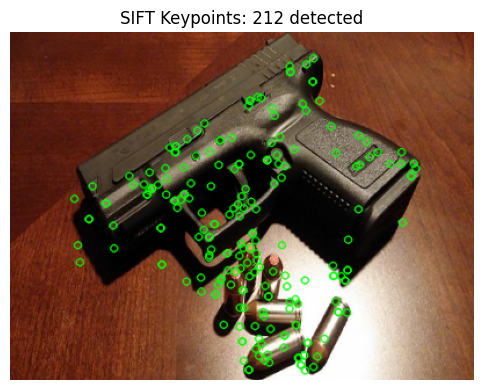

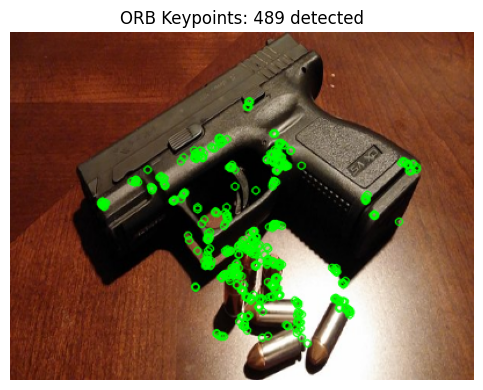

In [64]:
img_path = r"G:\Work\visual recognition\project\Data\test\gun\gun1.jpeg"
img = cv2.imread(img_path)
resized, filtered = cv2.resize(img, (400, 300)), cv2.medianBlur(cv2.resize(img, (400, 300)), 5)

# Segment image
segmented = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)

# Compare feature extractors
start = time.time()
keypoints_dict = compare_feature_extractors(segmented)
end = time.time()

print(f"Feature extraction time: {end - start:.2f} seconds")

# Visualize results
visualize_keypoints(resized, keypoints_dict)

In [88]:
def evaluate(directory, label):
    correct, total = 0, 0
    false_positives, false_negatives = 0, 0

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(directory, filename)
            img = cv2.imread(path)
            resized, filtered = preprocess_image(img)
            segmented = segment_colors(filtered, k=3)
            gray = cv2.cvtColor(segmented.astype('uint8'), cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
            descriptors = extract_features(closed)

            prediction = 0
            if descriptors is not None:
                ratio = match_features(descriptors, reference_descriptors)
                prediction = 1 if ratio >= 0.5 else 0

            if prediction == label:
                correct += 1
            else:
                if prediction == 1:
                    false_positives += 1
                else:
                    false_negatives += 1
            total += 1

    accuracy = correct / total if total else 0
    print(f"Evaluated {directory}: Accuracy={accuracy:.2f}, TP={correct}, FP={false_positives}, FN={false_negatives}")

In [91]:
# Example usage:
evaluate(r'Data\test\gun', label=1)
#evaluate("data/test/nongun", label=0)

Evaluated Data\test\gun: Accuracy=0.50, TP=2, FP=0, FN=2


In [8]:
import cv2
import numpy as np

# Load your reference descriptors (make sure the path is correct)
#reference_descriptors = np.load("Data/descriptors/gun1_freak.npy")

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Cannot open webcam.")
    exit()

print("📸 Press 'c' to capture and detect. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame.")
        break

    # Show the live feed
    display_frame = frame.copy()
    cv2.putText(display_frame, "Press 'c' to capture", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    cv2.imshow("Gun Detection Feed", display_frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('c'):
        print("🔍 Capturing and processing frame...")
        try:
            resized, filtered = preprocess_image(frame)
            segmented = segment_colors(filtered, k=3)
            gray = cv2.cvtColor(segmented.astype('uint8'), cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

            descriptors = extract_features(closed)

            if descriptors is not None and len(descriptors) > 0:
                match_ratio = match_features(descriptors, reference_descriptors)
                if match_ratio >= 0.5:
                    print(f"🔴 Gun Detected! (Match Ratio: {match_ratio:.2f})")
                else:
                    print(f"🟢 No Gun Detected. (Match Ratio: {match_ratio:.2f})")
            else:
                print("⚠️ No descriptors extracted from frame.")
        except Exception as e:
            print(f"❌ Error: {e}")

    elif key == ord('q'):
        print("👋 Exiting.")
        break

cap.release()
cv2.destroyAllWindows()


📸 Press 'c' to capture and detect. Press 'q' to quit.
🔍 Capturing and processing frame...
🟢 No Gun Detected. (Match Ratio: 0.01)
👋 Exiting.
